# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

**Installing surprise library**

## **Importing the necessary libraries and overview of the dataset**

In [ ]:
import warnings                                 # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')

import numpy as np                              # Basic libraries of python for numeric and dataframe computations
import pandas as pd

import matplotlib.pyplot as plt                 # Basic library for data visualization
import seaborn as sns                           # Slightly advanced library for data visualization

from collections import defaultdict             # A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error  # A performance metrics in sklearn

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:

df = (
    pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ratings_Electronics.csv', header=None)
    .rename(columns={0: 'user_id', 1: 'prod_id', 2: 'rating', 3: 'timestamp'})    # set column names
    .drop(columns=['timestamp'])
)


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [ ]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [ ]:
# Check the number of rows and columns and provide observations

df_final.shape


(65290, 3)

Observations: 3 Columns, 65290 Rows

### **Data types**

In [ ]:
# Check Data types and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Write your observations here: user_id and prod_id are strings, while rating is a numeric value**

### **Checking for missing values**

In [ ]:
# Check for missing values present and provide observations
df_final.isnull().sum()

,0
user_id,0
prod_id,0
rating,0


**Write your observations here: There are no MIssing Values**

### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable and provide observations
df_final.describe()


,rating
count,65290.000000
mean,4.294808
std,0.988915
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


**Write your observations here: Takes values 1 - 5, and has the central tendency of mean = 4.29 +- 0.98 (sd). Looking at the quartiles, the median rating is 5.0, meaning that 50% of the ratings are 5 stars while only 25% of the ratings are 4.0 stars or worse **

### **Checking the rating distribution**

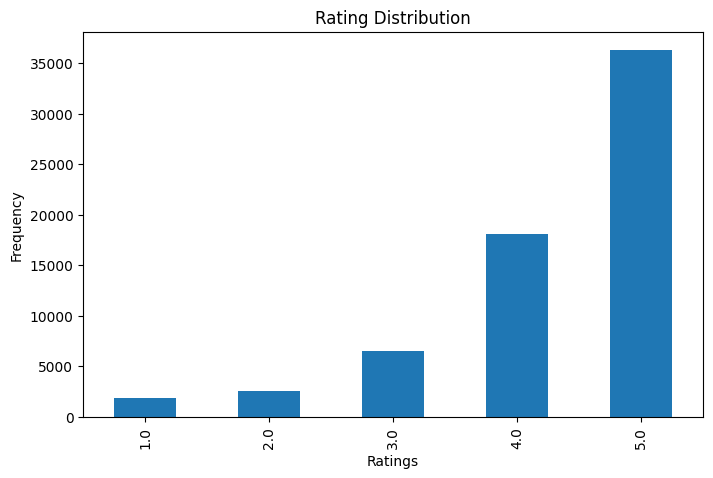

In [ ]:
# Create the bar plot and provide observations
df_final['rating'].value_counts().sort_index().plot(kind='bar', figsize=(8, 5), title='Rating Distribution', )
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.show()


**Write your observations here: The data is heavily left skewed and the majority of the ratings are 4.0 and 5.0**

### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data

print(f'Total Rows = {df_final.shape[0]}')      #shape[0] returns rows while shape[1] returns columns

# nunique() returns the number of unique entries

print(f"Unique users = {df_final['user_id'].nunique()}")

print(f"Unique products = {df_final['prod_id'].nunique()}")



Total Rows = 65290
Unique users = 1540
Unique products = 5689


**Write your observations here: There are 65,290 total ratings from 1,540 unique users across 5,689 unique products**

### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings

df_final['user_id'].value_counts().head(10)


,count
user_id,
ADLVFFE4VBT8,295
A3OXHLG6DIBRW8,230
A1ODOGXEYECQQ8,217
A36K2N527TXXJN,212
A25C2M3QF9G7OQ,203
A680RUE1FDO8B,196
A1UQBFCERIP7VJ,193
A22CW0ZHY3NJH8,193
AWPODHOB4GFWL,184


**Write your observations here: The top 10 users have between 179 and 295 ratings**

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate the average rating for each product
avg_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'average_rating': avg_rating, 'rating_count': count_rating})

# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values(by='average_rating', ascending=False)

# See the first five records of the "final_rating" dataset
final_rating.head()


,average_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):
# Finding products with minimum number of interactions
 recommendations = final_rating[final_rating['rating_count'] > min_interaction]
 # Sorting values w.r.t average rating
 recommendations = recommendations.sort_values(by = 'average_rating', ascending = False)
 return recommendations.index[:n]


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
list(top_n_products(final_rating, 5, 50)) # n = 5 products min_interactions = 50

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
list(top_n_products(final_rating, 5, 100))  # n = 5 products min_interactions = 100

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0,5))
# Loading the rating dataset
data = Dataset.load_from_df(df_final,reader)
# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state= 1)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
sim_options = {
    'name': 'cosine',  # Using cosine similarity
    'user_based': True  # This is a user-user similarity-based recommendation system
}
# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
user_user_model= KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

# Fit the model on the training data
user_user_model.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(user_user_model)

RMSE: 1.0260
Precision:  0.844
Recall:  0.862
F_1 score:  0.853


**Observations:**

**RMSE**: 1.0260 is the average prediction error for ratings scaled between 0 and 5. This value is relatively low (lower is better), but it can be improved.

**Precision & Recall** : 84.4% of reccomendations were relevant (Precision) and 86.6% of ALL recommended items were retrieved. This is pretty decent as these metrics indicate the quality and completeness of the reccomendations, respectively.

**F1 - Score**: 0.853 is a harmonic mean of Precision and Recall, balancing both metrics.
This indicates that the system achieves a good balance between recommending only relevant items and capturing all relevant items.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
user_user_model.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.33   {'actual_k': 6, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.3333333333333335, details={'actual_k': 6, 'was_impossible': False})

**Write your observations here:__________**

The estimated rating (3.33) understates the actual rating of 5 (r_ui = 5).

The actual_k is the number of neighbors that the prediction was based on that was_impossible: False indicates that the prediction was successfully made.

Further tuning required.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
potential_users = df_final[df_final.prod_id != "1400501466"].user_id.unique()
potential_users

array(['A2ZR3YTMEEIIZ4', 'A3CLWR1UUZT6TG', 'A5JLAU2ARJ0BO', ...,
       'A215WH6RUDUCMP', 'A38C12950IM24P', 'A2J4XMWKR8PPD0'], dtype=object)

In [ ]:
# Check if the specific user ID is in the list of potential users
is_potential_user = "A34BZM6S9L7QI4" in potential_users

print(f"Is 'A34BZM6S9L7QI4' a potential user? {is_potential_user}")

Is 'A34BZM6S9L7QI4' a potential user? True


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
user_user_model.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)


user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 1.99   {'actual_k': 2, 'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=1.991150442477876, details={'actual_k': 2, 'was_impossible': False})

**observations**

**r_ui** = None means there is no ground truth so the prediction is based purely on the model

**est** = 1.99 is the estimated rating. Which is low, suggesting that the model considers this product unlikely to be of interest to the user

**actual_k** = 2: Prediction formed based on 2 neighbors. The low number of neighbors may contribute to the low confidence.

**was_impossible** = False: there was sufficient data to make the prediction

The prediction (1.99) indicates the system does not expect the user to find this product highly relevant. Sparse data for the user or product may limit the prediction's accuracy, highlighting the need for strategies to mitigate cold start and sparsity issues.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [40, 60, 80],  # Number of neighbors
    'sim_options': {
        'name': ['cosine', 'pearson', 'pearson_baseline'],  # Similarity metrics
        'user_based': [True]  # User-user collaborative filtering
    }
}

# Performing 3-fold cross-validation to tune the hyperparameters
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
grid_search.fit(data)

# Best RMSE score
print(f"Best RMSE: {grid_search.best_score['rmse']}")

# Combination of parameters that gave the best RMSE score
print(f"Best parameters: {grid_search.best_params['rmse']}")

Best RMSE: 1.033515459859076
Best parameters: {'k': 40, 'sim_options': {'name': 'pearson', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
best_sim = {
    'name': 'pearson',  # Optimal similarity measure
    'user_based': True  # User-user collaborative filtering
}
# Creating an instance of KNNBasic with optimal hyperparameter values

optimal_user_user_model = KNNBasic(sim_options = best_sim,k = 40, min_k = 3, verbose = False, random_state = 1) # increase the minimum neighbors in attempt to increase precision

# Training the algorithm on the trainset
optimal_user_user_model.fit(trainset)

# Let us compute precision@k and recall@k also with k =10

precision_recall_at_k(optimal_user_user_model, k = 10, threshold = 3.0)   # lowered the threshold from 3.5 to 3.0 in attempt to increase Recall (minimum estimate considered relevant)

RMSE: 0.9986
Precision:  0.922
Recall:  0.906
F_1 score:  0.914


In [ ]:
# Compare with previous model:

precision_recall_at_k(user_user_model)

RMSE: 1.0260
Precision:  0.844
Recall:  0.862
F_1 score:  0.853


**Write your observations here:__________**



*   The improved **RMSE** (0.9986 vs 1.260) shows the model is making more accurate rating predictions after the hyperparameter adjustments.
*   **Precision** increased significantly (0.922 vs 0.844) reflecting the improved quality of recommendations.
*   The higher **recall** (0.906 vs 0.862) demonstrating the model's enhanced ability to retrieve relevant items for users.
*    Overall, **F1-Score** is better than previous (0.861 vs 0.853)


The optimized model outperforms the initial model across all metrics, showing significant improvements in both rating accuracy (RMSE) and recommendation relevance (Precision, Recall, and F1-Score).
The leap in precision and recall indicates that the optimization successfully enhanced both the relevance and coverage of recommendations.


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
optimal_user_user_model.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.30   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.296427477408486, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
optimal_user_user_model.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)


user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.30   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.296427477408486, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:**

**Prediction for user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**

The Optimized Model saw closer estimated ratings (4.30) to the ground truth (5.0) compared to the intial model (3.33)
The optimized model requires more neighbors (min_k = 3), resulting in was_impossible = True


**Prediction rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**

Optmized model also returned estimated rating of 4.3 when the r_ui was not provided. This is different from the intial model where (1.99) would not have made the threshhold limit.


**Model Trade-Offs:**

Optimized Model:
The optimized model prioritizes higher prediction accuracy, as evident in its significantly improved estimated ratings.
However, its strict requirements (e.g., higher min_k) mean it may fail to make predictions for sparse data or cold-start scenarios, as seen in these examples.



### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user
optimal_user_user_model.get_neighbors(0,5)

[38, 199, 456, 484, 806]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, optimal_user_user_model)


In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B0015DYMVO,4.612005
1,1400532655,4.296427
2,1400599997,4.296427
3,9983891212,4.296427
4,B00000DM9W,4.296427


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options
item_item_sim_options = {'name': 'cosine', 'user_based': False}   # user_based = False to get item-item simmilarities

# KNN algorithm is used to find desired similar items. Use random_state=1

item_item_model = KNNBasic(sim_options= item_item_sim_options, verbose = False, random_state = 1)

# Train the algorithm on the trainset, and predict ratings for the test set

item_item_model.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(item_item_model)


RMSE: 1.0147
Precision:  0.826
Recall:  0.853
F_1 score:  0.839


In [ ]:
# Define accuracy metrics for each model
accuracy_data = {
    'Model': ['Initial User-User', 'Optimized User-User', 'Initial Item-Item'],
    'RMSE': [1.0260, 0.9986, 1.0147],
    'Precision': [0.844, 0.922, 0.826],
    'Recall': [0.862, 0.906, 0.853],
    'F1-Score': [0.853, 0.914, 0.839]
}

# Create a DataFrame
accuracy_df = pd.DataFrame(accuracy_data)
accuracy_df

,Model,RMSE,Precision,Recall,F1-Score
0,Initial User-User,1.0260,0.844,0.862,0.853
1,Optimized User-User,0.9986,0.922,0.906,0.914
2,Initial Item-Item,1.0147,0.826,0.853,0.839


**Write your observations here:**____________

The Item-Item similarity model has a slighly better RMSE to the intial User-User Model (1.0147 vs 1.026) but has marginally lower Precision, Recall, and F1-Score.

The accuracy is far worse compared to the optimzied user-user similarity model

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
def find_rating(df, user_id, prod_id):
  # return df['rating'] when df['user_id']== user_id and df['prod_id'] == prod_id. If prod_id does not exist, return None

  # Filter the DataFrame for the specified user_id and prod_id
    filtered = df[(df['user_id'] == user_id) & (df['prod_id'] == prod_id)].copy()

    # Check if the filtered DataFrame has any rows
    if not filtered.empty:
        # Return the rating
        return filtered['rating'].iloc[0]
    else:
        # Return None if no matching entry is found
        print('User has not interacted with this product')
        return None

find_rating(df_final, 'A3LDPF5FMB782Z', '1400501466')


5.0

In [ ]:
# Predicting rating for a sample user with an interacted product
item_item_model.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.30   {'actual_k': 20, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.3, details={'actual_k': 20, 'was_impossible': False})

**Write your observations here:**____________

* The estimated rating is 4.3 which is interestingly the same as the optimzed user-user model and much higher than the intial user-user model (3.33)
* The actual k was 20 (items) compared to 6 (users) and the prediction was possible, unlike the optimized user-user model

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [ ]:
find_rating(df_final, 'A34BZM6S9L7QI4', '1400501466')

User has not interacted with this product


In [ ]:
# Predicting rating for a sample user with a non interacted product
item_item_model.predict('A34BZM6S9L7QI4', '1400501466',  verbose=True)  # omit r_ui since user has not interacted with this product


user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.00   {'actual_k': 4, 'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.0, details={'actual_k': 4, 'was_impossible': False})

**Write your observations here:**____________

Item-Item estimated rating was much higher than intial user-user estimated rating (4.00 vs 1.99), which would result in this item being recommended to the user when this model is used.

This prediction was also possible with 4 actual neighbors. (Initial user-user model had 2 neighbors)

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [10, 20, 30],  # Number of neighbors
    'min_k': [3, 6, 9],  # Minimum neighbors required for prediction
    'sim_options': {
        'name': ['msd', 'cosine'],  # Similarity metrics
        'user_based': [False]  # Item-item collaborative filtering
    }
}

# Performing 3-fold cross-validation to tune the hyperparameters
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
grid_search.fit(data)

# Find the best RMSE score
print(f"Best RMSE score: {grid_search.best_score['rmse']}")

# Find the combination of parameters that gave the best RMSE score
best_params = grid_search.best_params['rmse']
print(f"Best parameters: {best_params}")

Best RMSE score: 0.9748246724968249
Best parameters: {'k': 20, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering
best_item_options = {
    'name': 'msd',  # Optimal similarity measure
    'user_based': False  # Item-Item collaborative filtering
}
# Creating an instance of KNNBasic with optimal hyperparameter values

optimal_item_item_model = KNNBasic(sim_options = best_item_options, k = 20, min_k = 6, verbose = False, random_state = 1) # set min_k, k based on the value returned from grid_search

# Training the algorithm on the trainset
optimal_item_item_model.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(optimal_item_item_model, k = 10, threshold = 3.0) # again, lower threshold to increase recall

RMSE: 0.9752
Precision:  0.923
Recall:  0.905
F_1 score:  0.914


In [ ]:
optimal_item_item_performance = {
    'Model': 'Optimal Item-Item',
    'RMSE': 0.9752,
    'Precision': 0.923,
    'Recall': 0.905,
    'F1-Score': 0.914
}

# Convert the new row to a DataFrame
new_row_df = pd.DataFrame([optimal_item_item_performance])

# Concatenate the new row with the existing DataFrame
accuracy_df = pd.concat([accuracy_df, new_row_df], ignore_index=True)
accuracy_df

,Model,RMSE,Precision,Recall,F1-Score
0,Initial User-User,1.0260,0.844,0.862,0.853
1,Optimized User-User,0.9986,0.922,0.906,0.914
2,Initial Item-Item,1.0147,0.826,0.853,0.839
3,Optimal Item-Item,0.9752,0.923,0.905,0.914


**Write your observations here:__________**
* We see that the optimized Item-Item model has very similar precision, recall, and f1-score as the optimed User-User model. However, the RMSE is marginally better (0.9752 vs 0.9986)
* The performance is better than the initial Item-Item and intial User-User models across all metrics


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
optimal_item_item_model.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.62   {'actual_k': 20, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.617647058823531, details={'actual_k': 20, 'was_impossible': False})

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
optimal_item_item_model.predict('A34BZM6S9L7QI4', '1400501466',  verbose=True)  # omit r_ui since user has not interacted with this product

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.30   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.296427477408486, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:__________**

**"A3LDPF5FMB782Z" and productId "1400501466"**

* Optimized Item-Item model has the closest estimated rating out of all models (4.62) vs 4.30 for Optimized User-User and Initial Item-Item, vs 3.33 for Initial User-User
* this prediction was also possible, unlike the optimal user-user model which did not have enough neighbors - highlighting its strength in dense product interaction scenarios

**"A34BZM6S9L7QI4" and productId "1400501466"**
* predicted the same estimated value as the optimized user-user model (4.3)
* also impossible due to not enough neighbors, suggesting both models struggle in sparse data scenarios for this particular user/product combination

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
optimal_item_item_model.get_neighbors(0,5)

[2, 4, 9, 12, 13]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, optimal_item_item_model)


In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])


,prod_id,predicted_ratings
0,1400532655,4.296427
1,1400599997,4.296427
2,9983891212,4.296427
3,B00000DM9W,4.296427
4,B00000J1V5,4.296427


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Initialize the SVD model with random_state=1
svd_model = SVD(random_state=1)

# Training the algorithm on the trainset
svd_model.fit(trainset)

# Use precision_recall_at_k to compute metrics
precision_recall_at_k(svd_model, k=10, threshold=3.5)

RMSE: 0.9104
Precision:  0.837
Recall:  0.88
F_1 score:  0.858


In [ ]:
optimal_item_item_performance = {
    'Model': 'Singular Value Decomposition',
    'RMSE': 0.9104,
    'Precision': 0.837,
    'Recall': 0.88,
    'F1-Score': 0.858
}

# Convert the new row to a DataFrame
new_row_df = pd.DataFrame([optimal_item_item_performance])

# Concatenate the new row with the existing DataFrame
accuracy_df = pd.concat([accuracy_df, new_row_df], ignore_index=True)
accuracy_df

,Model,RMSE,Precision,Recall,F1-Score
0,Initial User-User,1.0260,0.844,0.862,0.853
1,Optimized User-User,0.9986,0.922,0.906,0.914
2,Initial Item-Item,1.0147,0.826,0.853,0.839
3,Optimal Item-Item,0.9752,0.923,0.905,0.914
4,Singular Value Decomposition,0.9104,0.837,0.880,0.858


**Write your observations here:___________**
* at Threshold = 3.5, the SVD model has bettere Recall and F1-Score compared to the Initial Item-Item and Intial User-User model. It only has better Precision compared to the intial Item-item model (0.837 vs 0.826) but has lower precision comapred to the intial user-user model (0.844).
* SVD has the lowest RMSE, indicating that this model is the most reliable model thus far.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction
svd_model.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.09   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.094312160755627, details={'was_impossible': False})

**Write your observations here:___________**
* estimated rating (4.09) is higher than the initial user-user model (3.33) but lower than intial item-item model (4.30). This is a good middle ground, where it is only marginally less accurate comapred to the optimized Item-Item estimate (4.62)

* This estimate was possible with the available data

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
svd_model.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.05   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.051141373805704, details={'was_impossible': False})

**Write your observations here:___________**
* 4.05 is significantly higher than the initial User-User estimate (1.99) and slighly lower than the Optimized User-user and Optimized Item-Item (4.30)
* This prediction, is however, possible, compared to the optimized user-user and optimized item-item models, which `was_impossible = True`,  highlighting it's utility for sparse interactions between user and items.  

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
param_grid = {
    'n_epochs': [10, 20, 30],  # Number of training epochs
    'lr_all': [0.002, 0.005, 0.01],  # Learning rate for all parameters
    'reg_all': [0.02, 0.1, 0.2]  # Regularization term for all parameters
}

# Performing 3-fold gridsearch cross-validation
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
grid_search.fit(data)

# Best RMSE score
best_rmse = grid_search.best_score['rmse']
print(f"Best RMSE score: {best_rmse}")

# Combination of parameters that gave the best RMSE score
best_params = grid_search.best_params['rmse']
print(f"Best parameters: {best_params}")

Best RMSE score: 0.8989396326271267
Best parameters: {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1

# Train the algorithm on the trainset

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE


In [ ]:
# Build the optimized SVD model using the best parameters
optimized_svd_model = SVD(n_epochs=20, lr_all=0.01, reg_all=0.2, random_state=1)

# Train the algorithm on the trainset
optimized_svd_model.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(optimized_svd_model, k=10, threshold=3.0)

RMSE: 0.9014
Precision:  0.926
Recall:  0.904
F_1 score:  0.915


In [ ]:
optimal_svd_performance = {
    'Model': ' Optimized Singular Value Decomposition',
    'RMSE': 0.9014,
    'Precision': 0.926,
    'Recall': 0.904,
    'F1-Score': 0.915
}

# Convert the new row to a DataFrame
new_row_df = pd.DataFrame([optimal_svd_performance])

# Concatenate the new row with the existing DataFrame
accuracy_df = pd.concat([accuracy_df, new_row_df], ignore_index=True)
accuracy_df

,Model,RMSE,Precision,Recall,F1-Score
0,Initial User-User,1.0260,0.844,0.862,0.853
1,Optimized User-User,0.9986,0.922,0.906,0.914
2,Initial Item-Item,1.0147,0.826,0.853,0.839
3,Optimal Item-Item,0.9752,0.923,0.905,0.914
4,Singular Value Decomposition,0.9104,0.837,0.880,0.858
5,Optimized Singular Value Decomposition,0.9014,0.926,0.904,0.915


**Write your observations here:_____________**
* The optimized SVD model (at 3.0 threshold) has the best RMSE (0.926) , Precision (0.926), and F1-Score (0.915). Only losing to the Optimized Item-Item Recall score by 0.01 and the Optimized User-User recall score by 0.02.
* With the added benefit of being able to deal with sparse data and non-iteraction scenarios, the optimized SVD model is the best reccomendation model tested within this analysis

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
optimized_svd_model.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.09   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.090441179731308, details={'was_impossible': False})

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
optimized_svd_model.predict('A34BZM6S9L7QI4', '1400501466' ,verbose=True)


user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.06   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.06446285064312, details={'was_impossible': False})

### **Conclusion and Recommendations**

In [ ]:
# All Predictions

# Data for the predictions from different models
prediction_results = {
    'Model': [
        'Initial User-User', 'Optimized User-User', 'Initial Item-Item',
        'Optimized Item-Item', 'Initial SVD', 'Optimized SVD'
    ],
    'User A3LDPF5FMB782Z (r_ui=5) - est': [3.33, 4.30, 4.30, 4.62, 4.09, 4.09],
    'User A3LDPF5FMB782Z (r_ui=5) - actual_k': [6, None, 20, 20, None, None],
    'User A3LDPF5FMB782Z (r_ui=5) - was_impossible': [False, True, False, False, False, False],
    'User A34BZM6S9L7QI4 (r_ui=None) - est': [1.99, 4.30, 4.00, 4.30, 4.05, 4.06],
    'User A34BZM6S9L7QI4 (r_ui=None) - actual_k': [2, None, 4, None, None, None],
    'User A34BZM6S9L7QI4 (r_ui=None) - was_impossible': [False, True, False, True, False, False]
}

# Create the DataFrame
predictions_df = pd.DataFrame(prediction_results)

# Updated model thresholds
model_thresholds = {
    'Model': [
        'Initial User-User', 'Optimized User-User', 'Initial Item-Item',
        'Optimized Item-Item', 'Initial SVD', 'Optimized SVD'
    ],
    'Threshold': [3.5, 3.0, 3.5, 3.0, 3.5, 3.0]
}

# Merge thresholds into the predictions DataFrame
thresholds_df = pd.DataFrame(model_thresholds)
predictions_df = predictions_df.merge(thresholds_df, on='Model')

predictions_df

,Model,User A3LDPF5FMB782Z (r_ui=5) - est,User A3LDPF5FMB782Z (r_ui=5) - actual_k,User A3LDPF5FMB782Z (r_ui=5) - was_impossible,User A34BZM6S9L7QI4 (r_ui=None) - est,User A34BZM6S9L7QI4 (r_ui=None) - actual_k,User A34BZM6S9L7QI4 (r_ui=None) - was_impossible,Threshold
0,Initial User-User,3.33,6.0,False,1.99,2.0,False,3.5
1,Optimized User-User,4.30,NaN,True,4.30,NaN,True,3.0
2,Initial Item-Item,4.30,20.0,False,4.00,4.0,False,3.5
3,Optimized Item-Item,4.62,20.0,False,4.30,NaN,True,3.0
4,Initial SVD,4.09,NaN,False,4.05,NaN,False,3.5
5,Optimized SVD,4.09,NaN,False,4.06,NaN,False,3.0


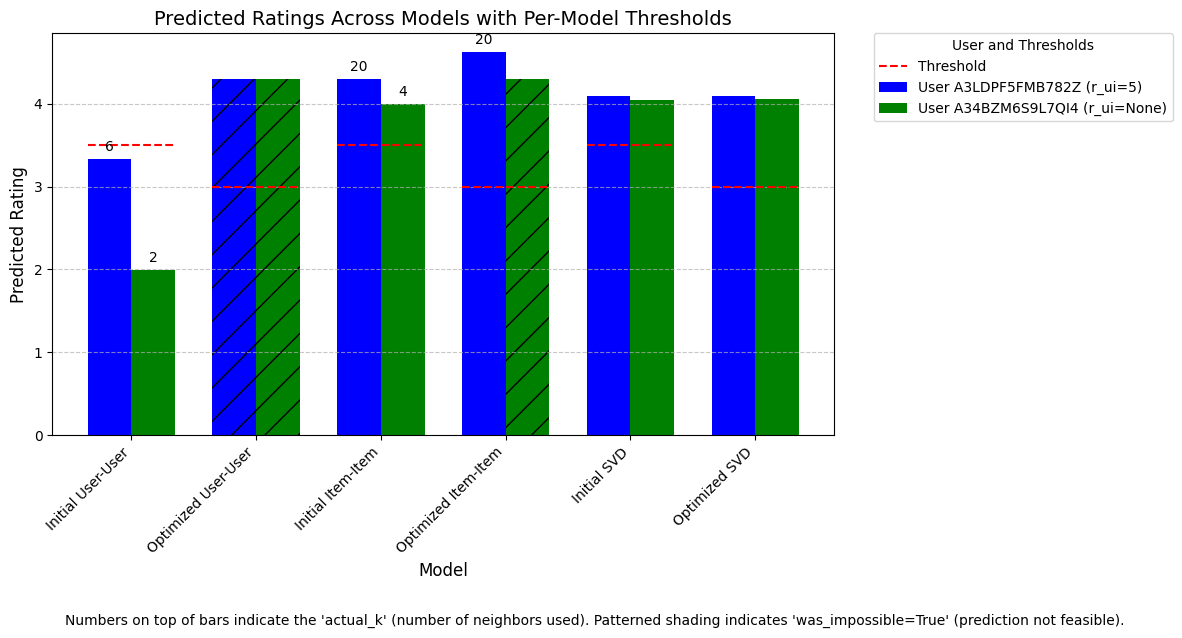

In [ ]:

# Recreate the plot with per-model thresholds
fig, ax = plt.subplots(figsize=(12, 6))

# Bar plot for User A3LDPF5FMB782Z
bars1 = ax.bar(
    x - width/2,
    predictions_df['User A3LDPF5FMB782Z (r_ui=5) - est'],
    width,
    label='User A3LDPF5FMB782Z (r_ui=5)',
    color='blue',
    hatch=['/' if was_imp else '' for was_imp in predictions_df['User A3LDPF5FMB782Z (r_ui=5) - was_impossible']]
)

# Add labels for actual_k on User A3LDPF5FMB782Z bars
for bar, actual_k in zip(bars1, predictions_df['User A3LDPF5FMB782Z (r_ui=5) - actual_k']):
    if actual_k > 0:  # Only label bars with actual_k > 0
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                str(int(actual_k)), ha='center', fontsize=10, color='black')

# Bar plot for User A34BZM6S9L7QI4
bars2 = ax.bar(
    x + width/2,
    predictions_df['User A34BZM6S9L7QI4 (r_ui=None) - est'],
    width,
    label='User A34BZM6S9L7QI4 (r_ui=None)',
    color='green',
    hatch=['/' if was_imp else '' for was_imp in predictions_df['User A34BZM6S9L7QI4 (r_ui=None) - was_impossible']]
)

# Add labels for actual_k on User A34BZM6S9L7QI4 bars
for bar, actual_k in zip(bars2, predictions_df['User A34BZM6S9L7QI4 (r_ui=None) - actual_k']):
    if actual_k > 0:  # Only label bars with actual_k > 0
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                str(int(actual_k)), ha='center', fontsize=10, color='black')

# Add threshold lines for each model
for i, threshold in enumerate(predictions_df['Threshold']):
    ax.hlines(threshold, x[i] - width, x[i] + width, colors='red', linestyles='dashed', label=f'Threshold' if i == 0 else "")


# Formatting
ax.set_xticks(x)
ax.set_xticklabels(predictions_df['Model'], rotation=45, ha='right', fontsize=10)
ax.set_title('Predicted Ratings Across Models with Per-Model Thresholds', fontsize=14)
ax.set_ylabel('Predicted Rating', fontsize=12)
ax.set_xlabel('Model', fontsize=12)
ax.legend(
    title="User and Thresholds",
    fontsize=10,
    loc='upper left',
    bbox_to_anchor=(1.05, 1),  # Move legend outside
    borderaxespad=0
)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.figtext(0.5, -0.05,
            "Numbers on top of bars indicate the 'actual_k' (number of neighbors used). "
            "Patterned shading indicates 'was_impossible=True' (prediction not feasible).",
            ha='center', fontsize=10, wrap=True)

# Show the plot
plt.show()


In [ ]:
accuracy_df['Model'].unique()

array(['Initial User-User', 'Optimized User-User', 'Initial Item-Item',
       'Optimal Item-Item', 'Singular Value Decomposition',
       ' Optimized Singular Value Decomposition'], dtype=object)

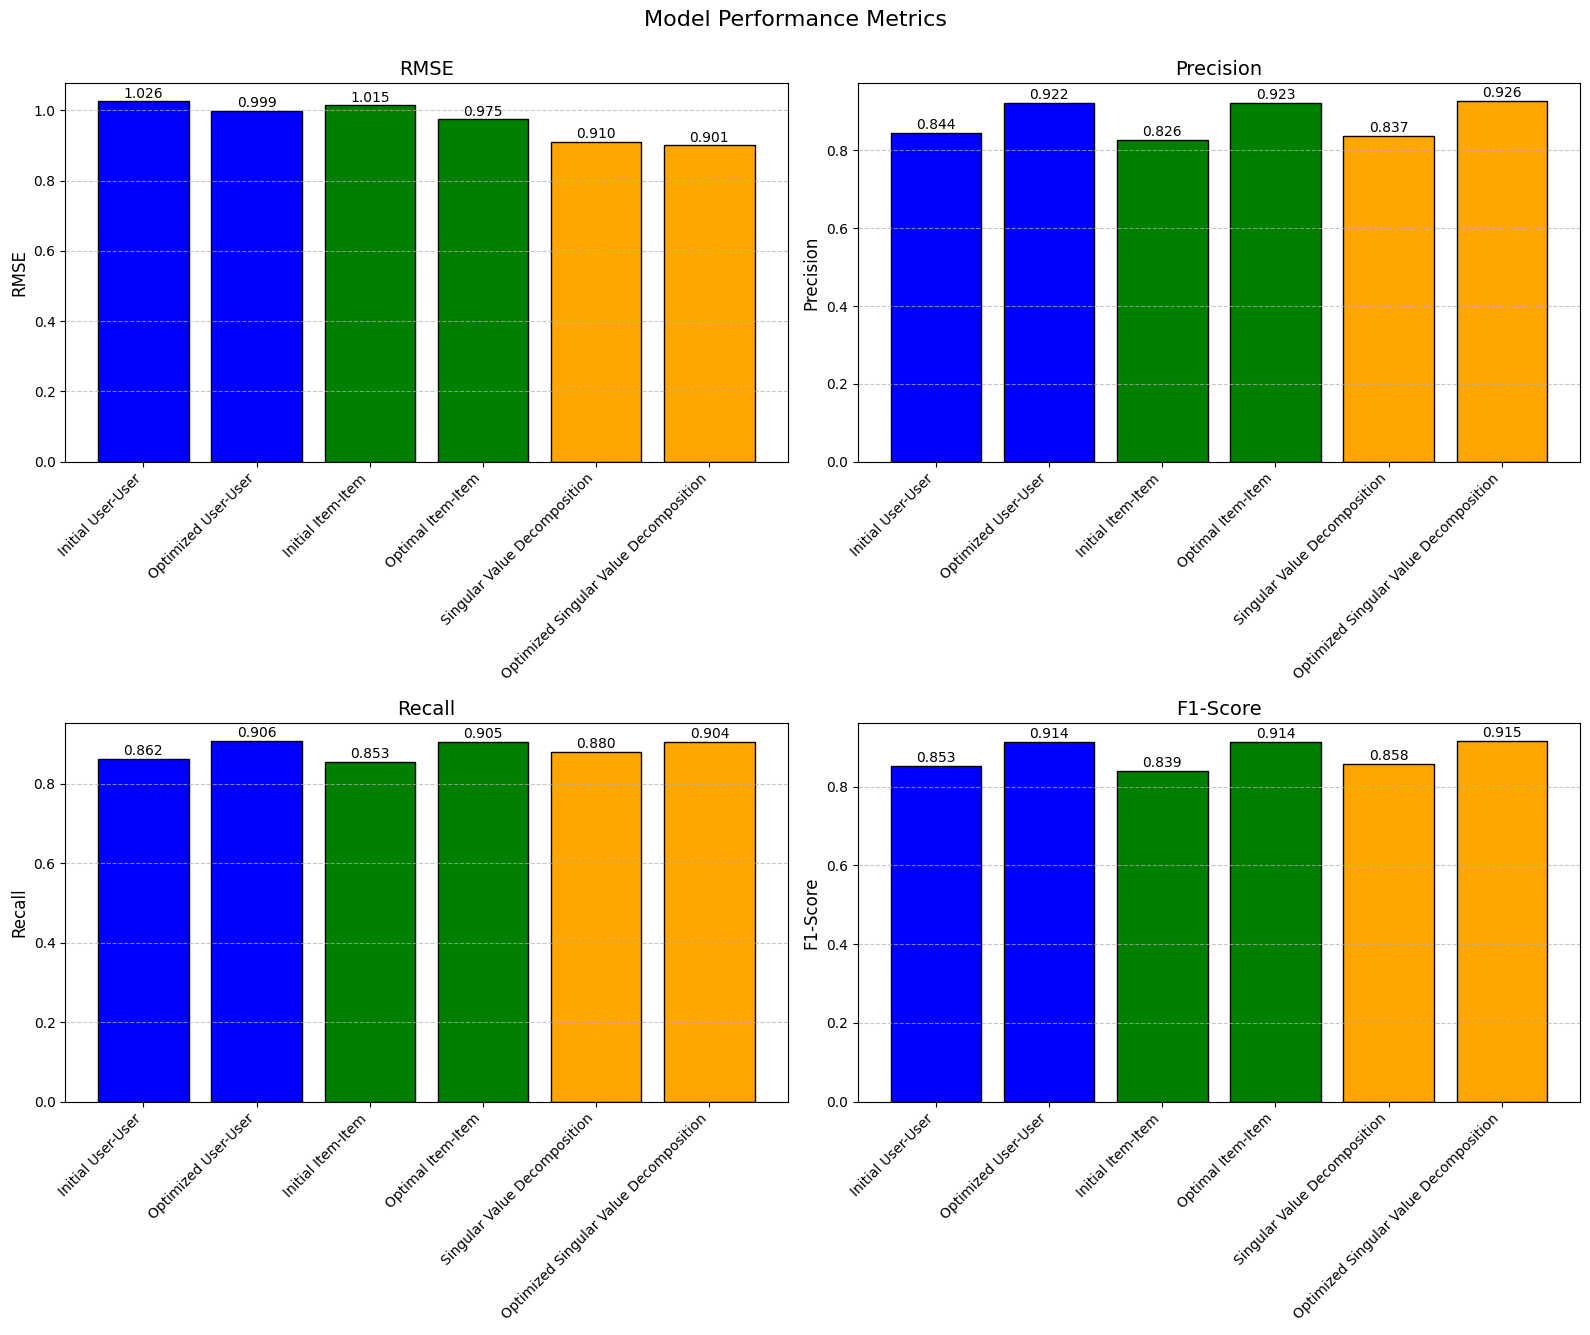

In [ ]:
# Assigning consistent colors to models
colors = {
    "Initial User-User": "blue",
    "Optimized User-User": "blue",
    "Initial Item-Item": "green",
    "Optimal Item-Item": "green",
    "Singular Value Decomposition": "orange",
    " Optimized Singular Value Decomposition": "orange"
}

# Create subplots for RMSE, Precision, Recall, and F1-Score
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
metrics = ["RMSE", "Precision", "Recall", "F1-Score"]

for ax, metric in zip(axes.flatten(), metrics):
    bars = ax.bar(
        accuracy_df["Model"],
        accuracy_df[metric],
        color=[colors[model] for model in accuracy_df["Model"]],
        edgecolor="black"
    )
    # Add values on top of the bars
    for bar, value in zip(bars, accuracy_df[metric]):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.01,
            f"{value:.3f}",
            ha="center",
            fontsize=10
        )
    ax.set_title(metric, fontsize=14)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_xticks(np.arange(len(accuracy_df["Model"])))
    ax.set_xticklabels(accuracy_df["Model"], rotation=45, ha="right", fontsize=10)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

fig.suptitle("Model Performance Metrics", fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plots
plt.show()


**Write your conclusion and recommendations here**


## Recommendations:

Based on the results, the **optimized SVD model** should be adopted as the primary recommendation system due to its superior performance across metrics, including the **lowest RMSE (0.9014)** and the **highest F1-Score (0.915)**. Its ability to handle sparse datasets and generalize user preferences makes it ideal for Amazon’s vast and diverse product catalog. To complement this, the **optimized Item-Item collaborative filtering model** can be deployed for categories with strong product relationships, such as co-purchased or similar items. This hybrid approach will leverage the strengths of both models to provide personalized and contextually relevant recommendations.

To enhance the system's ability to recommend a wider range of products, the rating threshold for relevance should be lowered from **3.5** to **3.0**, prioritizing recall. This ensures more products qualify as relevant, aligning with the goal of maximizing customer engagement by recommending more options. Continuous monitoring through A/B testing and feedback should be implemented to refine the system further and adapt to evolving customer preferences.


## Conclusion

The optimized SVD model, paired with a lowered threshold, provides a robust foundation for Amazon’s recommendation system, delivering personalized and accurate suggestions while maintaining broad coverage. By integrating Item-Item collaborative filtering as a complementary model, the system can dynamically cater to various recommendation contexts. These enhancements will improve customer satisfaction, increase product discoverability, and drive sales growth, ensuring Amazon remains a leader in delivering personalized shopping experiences.